# RNN implementation for dietary classification
In the following we'll try some RNN's implementations, starting from the BiLSTM architecture and following using Attention-based BiLSTM.

## Colab setup

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd /content/drive/MyDrive/datasets/distilbert_results

/content/drive/MyDrive/datasets/distilbert_results


In [2]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


## Imports

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Dataset Loading

In [5]:
#data = pd.read_csv('./dataset_balanced_10k.csv')
data = pd.read_csv('./dataset/dataset_balanced.csv')

In [8]:
data.head()

,cooking_method,ingredients,tags,Vegetarian,Dairy Free,Gluten Free,Low Carb,Low Fat,Low Sodium,Dessert,Meat,Fish,Dairy,Vegetarian&Dessert,Meat&Fish
0,"['Toast the Tuscan bread on a hot BBQ grill.',...",['4 large slices of Tuscan-style or dense coun...,"Italian,Bread,Low Sodium,Vegan",1,0,0,0,0,1,0,0,0,0,1,0
1,['Preheat the oven to 350 degrees F. Line the ...,"['1/2 cup regular olive oil, not extra-virgin,...","Easy Dessert Recipes,Dessert,Easy,Carrot Cake,...",0,0,1,0,0,1,1,0,0,0,1,0
2,['Simmer pear halves and brandy in a saucepan ...,"['2 cans pear halves, drained', '3 tablespoons...","American,Fruit,Pear Recipes,Pureeing Recipes,G...",1,0,1,0,1,1,0,0,0,0,1,0
3,"['In a large bowl, mix together the flour, sal...","['4 cups all purpose flour', '1 tablespoon sal...","Easy Main Dish,Easy,Main Dish,Easy Baking,Roas...",1,0,0,0,0,0,0,0,0,0,1,0
4,"['To soak beans: In a large bowl, cover beans ...","['1 pound dried small white beans, rinsed and ...","Easy Main Dish,Easy,Main Dish,Bean Soup,Beans ...",0,0,1,0,0,0,0,1,0,0,0,1


In [9]:
recipes = data['cooking_method']
labels_binary = data['Vegetarian&Dessert']
labels_multi = data[['Vegetarian&Dessert', 'Low Fat', 'Low Sodium', 'Low Carb', 'Gluten Free', 'Dairy Free']]

In [10]:
# Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Get GPU details if available
if tf.config.list_physical_devices('GPU'):
    gpu_info = tf.config.list_physical_devices('GPU')[0]
    print("GPU Name:", gpu_info.name)

TensorFlow version: 2.16.1
Num GPUs Available:  0


## Pre processing
We first need to tokenize all the recipes in order to feed the RNNs.

We'll do all of ours experiments using the entire recipe procedures, rather than just its ingredients

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(recipes)  # Fit the tokenizer on the texts

sequences = tokenizer.texts_to_sequences(recipes)

In [14]:
vocab_size = len(tokenizer.word_index) + 1

In [15]:
max_length = max(len(x) for x in sequences)
recipes_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', dtype='float32', value=0.0)  # Post-padding with zeros

In [16]:
recipes_sequences.shape

(50902, 535)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(recipes_sequences, labels_binary, test_size=0.3, random_state=42, stratify=labels_binary)

## Training the rnn

In [23]:
input_length = recipes_sequences.shape[1]

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',  min_delta=0.001, patience=3, verbose=1, mode='min', restore_best_weights=True)
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=512, input_length=input_length),
    Bidirectional(LSTM(1)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.7521 - loss: 0.5091 - val_accuracy: 0.9388 - val_loss: 0.2211
Epoch 2/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.9626 - loss: 0.1651 - val_accuracy: 0.9571 - val_loss: 0.1540
Epoch 3/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.9816 - loss: 0.0966 - val_accuracy: 0.9580 - val_loss: 0.1376
Epoch 4/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.9852 - loss: 0.0699 - val_accuracy: 0.9554 - val_loss: 0.1413
Epoch 5/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.9878 - loss: 0.0560 - val_accuracy: 0.9620 - val_loss: 0.1303
Epoch 6/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.9899 - loss: 0.0444 - val_accuracy: 0.9575 - val_loss: 0.1423
Epoch 7/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9910 - loss: 0.0385 - val_accuracy: 0.9559 - val_loss: 0.1494
Epoch 8/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.9918 - loss: 0.0353 - 

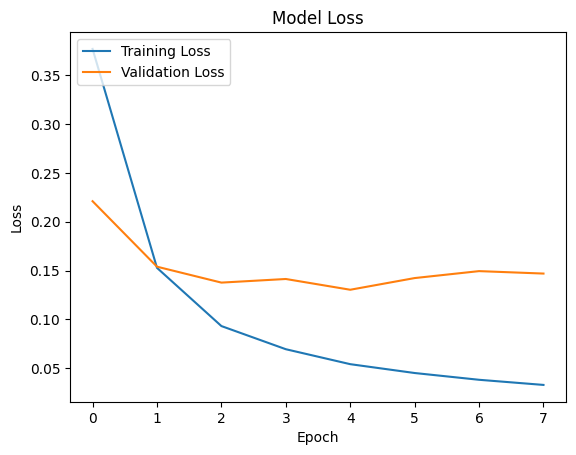

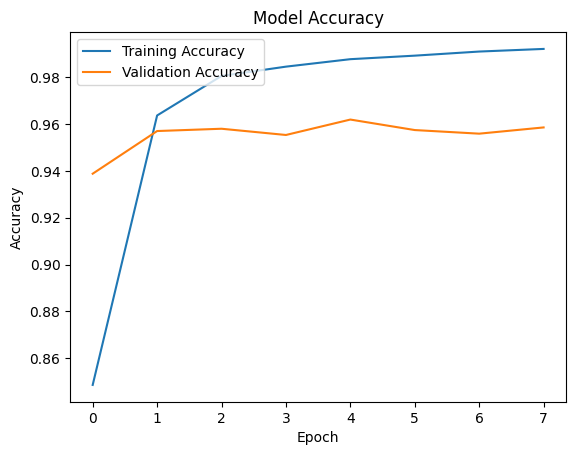

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)
conf_matrix = confusion_matrix(y_test, binary_predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
Accuracy: 0.9623469320935105
Precision: 0.9539609053497943
Recall: 0.9715782580222658
F1 Score: 0.9626889883849199
Confusion Matrix:
 [[7278  358]
 [ 217 7418]]


## Hyperparameter tuning
We'll try some configurations of hyperparameters in order to find the best parametrized one. Since we're dealing with binary classification we'll use the accuracy score as the objective of the search (notice that the dataset is balanced, thus giving accuracy representative power).

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp.Int('embedding_dim', min_value=32, max_value=512, step=32), input_length=input_length))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), dropout=hp.Float('dropout', 0, 0.5, step=0.1))))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss',  min_delta=0.001, patience=3, verbose=1, mode='min', restore_best_weights=True)
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='results',
    project_name='RNN_hlt')

tuner.search(X_train, y_train, epochs=5, validation_split=0.2, callbacks=[early_stopping])

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
trials = tuner.oracle.get_best_trials()
for trial in trials:
    print('Trial ID:', trial.trial_id)
    print('Score:', trial.score)
    print('Hyperparameters:', trial.hyperparameters.values)


In [ ]:
predictions = best_model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)

accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)
conf_matrix = confusion_matrix(y_test, binary_predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

## Adding an attention layer
The results obtained seem promising, and it might be advantageous to consider an attention based architecture in order to exploit the contextual relevance of each word considered.

In [25]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="orthogonal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Applying a simple attention mechanism
        e = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = inputs * a
        return tf.reduce_sum(output, axis=1)

    def get_config(self):
        return super(AttentionLayer, self).get_config()


In [26]:
embedding_dim = 512
lstm_units = 1

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(input_length,)),
    Bidirectional(LSTM(lstm_units, dropout=0.3, return_sequences=True)),
    BatchNormalization(),
    AttentionLayer(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 528, 512)          5523456   
                                                                 
 bidirectional_1 (Bidirecti  (None, 528, 2)            4112      
 onal)                                                           
                                                                 
 batch_normalization_1 (Bat  (None, 528, 2)            8         
 chNormalization)                                                
                                                                 
 attention_layer (Attention  (None, 2)                 530       
 Layer)                                                          
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                        

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',  min_delta=0.001, patience=5, verbose=1, mode='min', restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=256, callbacks=[early_stopping])

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.7139 - loss: 0.5724 - val_accuracy: 0.8281 - val_loss: 0.6148
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8999 - loss: 0.3323 - val_accuracy: 0.9103 - val_loss: 0.4049
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9566 - loss: 0.2132 - val_accuracy: 0.9586 - val_loss: 0.2289
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9764 - loss: 0.1455 - val_accuracy: 0.9593 - val_loss: 0.1637
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9832 - loss: 0.1074 - val_accuracy: 0.9585 - val_loss: 0.1422
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9871 - loss: 0.0845 - val_accuracy: 0.9580 - val_loss: 0.1335
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9897 - loss: 0.0664 - val_accuracy: 0.9617 - val_loss: 0.1273
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9898 - loss: 0.0560 - val_accu

Let's see the learning curve

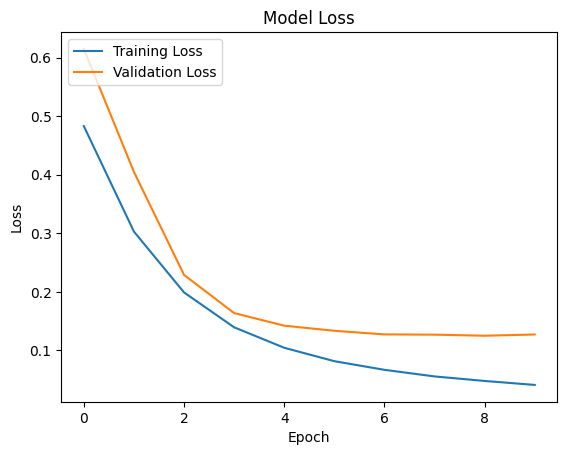

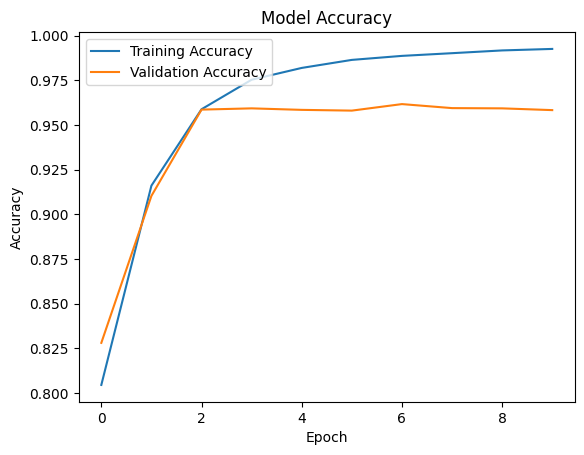

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)
conf_matrix = confusion_matrix(y_test, binary_predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

478/478 ━━━━━━━━━━━━━━━━━━━━ 115s 240ms/step
Accuracy: 0.9604479077990963
Precision: 0.946980292434838
Recall: 0.9755075311067453
F1 Score: 0.9610322580645161
Confusion Matrix:
 [[7219  417]
 [ 187 7448]]


### Some advanced grid search

In [ ]:
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=512, input_length=2123),
        Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                           dropout=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1),
                           return_sequences=True)),
        BatchNormalization(),
        AttentionLayer(),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'),
        beta_1=hp.Float('beta_1', min_value=0.85, max_value=0.95, step=0.01),
        beta_2=hp.Float('beta_2', min_value=0.990, max_value=0.999, step=0.001),
        epsilon=hp.Float('epsilon', min_value=1e-8, max_value=1e-6, sampling='LOG')
    )
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    directory='my_dir',
    project_name='intro_to_kt_optimizer_tuning'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal number of units: {best_hps.get('units')}
Optimal dropout rate: {best_hps.get('dropout')}
Optimal learning rate: {best_hps.get('learning_rate')}
Optimal beta_1: {best_hps.get('beta_1')}
Optimal beta_2: {best_hps.get('beta_2')}
Optimal epsilon: {best_hps.get('epsilon')}
""")


In [ ]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs=50, validation_split=0.2)

predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)
print("Confusion Matrix:\n", conf_matrix)

## Multi-class classification
Here we will address the problem of multi-class classification, i.e. we will classify each recipe as belonging to one or more dietary restrictions.

### Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(recipes_sequences, labels_multi, test_size=0.3, random_state=42)

In [ ]:
embedding_dim = 512
lstm_units = 1
num_labels = 6

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    Bidirectional(LSTM(lstm_units, dropout=0.3, return_sequences=True)),  # Ensure return_sequences is True for attention
    BatchNormalization(),
    AttentionLayer(),
    Dense(num_labels, activation='sigmoid')  # num_labels is the number of output classes
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min', restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, callbacks=[early_stopping])

Epoch 1/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1060s 1s/step - accuracy: 0.1622 - loss: 0.5603 - val_accuracy: 0.6102 - val_loss: 0.3422
Epoch 2/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1056s 1s/step - accuracy: 0.6140 - loss: 0.3241 - val_accuracy: 0.6018 - val_loss: 0.2750
Epoch 3/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1053s 1s/step - accuracy: 0.6422 - loss: 0.2463 - val_accuracy: 0.6127 - val_loss: 0.2343
Epoch 4/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1054s 1s/step - accuracy: 0.6582 - loss: 0.2136 - val_accuracy: 0.6293 - val_loss: 0.2203
Epoch 5/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1056s 1s/step - accuracy: 0.6732 - loss: 0.1920 - val_accuracy: 0.6700 - val_loss: 0.2132
Epoch 6/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1054s 1s/step - accuracy: 0.6797 - loss: 0.1777 - val_accuracy: 0.6388 - val_loss: 0.2090
Epoch 7/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1108s 1s/step - accuracy: 0.6845 - loss: 0.1714 - val_accuracy: 0.5939 - val_loss: 0.2116
Epoch 8/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1055s 1s/step - accuracy: 0.6829 - loss: 0.1640 - 

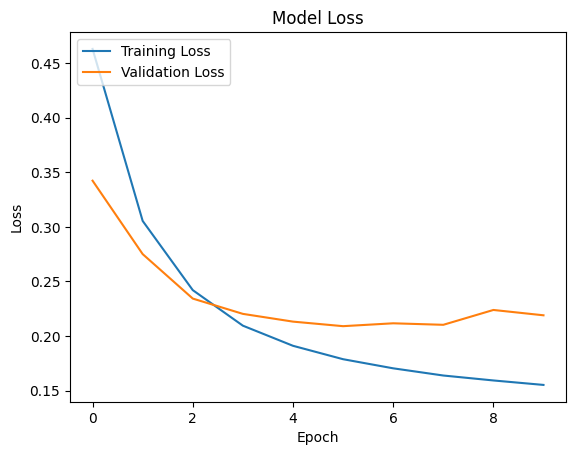

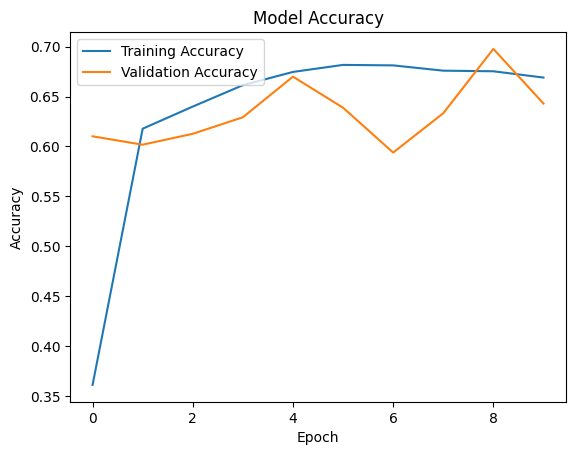

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

#### Macro Average

In [ ]:
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions, average='macro')
recall = recall_score(y_test, binary_predictions, average='macro')
f1 = f1_score(y_test, binary_predictions, average='macro')

print("Accuracy:", accuracy)
print("Precision (macro):", precision)
print("Recall (macro):", recall)
print("F1 Score (macro):", f1)

conf_matrices = []
for i in range(y_test.shape[1]):
    conf_matrix = confusion_matrix(y_test.iloc[:, i], binary_predictions[:, i])
    conf_matrices.append(conf_matrix)
    print(f"Confusion Matrix for label {y_test.columns[i]}:\n{conf_matrix}\n")
avg_conf_matrix = np.mean(conf_matrices, axis=0)
print("Average Confusion Matrix:\n", avg_conf_matrix)

478/478 ━━━━━━━━━━━━━━━━━━━━ 115s 240ms/step
Accuracy: 0.6207190098880231
Precision (macro): 0.5061810393712823
Recall (macro): 0.3940240067837122
F1 Score (macro): 0.4090346161846749
Confusion Matrix for label Vegetarian&Dessert:
[[7282  362]
 [ 354 7273]]

Confusion Matrix for label Low Fat:
[[13582    59]
 [ 1540    90]]

Confusion Matrix for label Low Sodium:
[[11262   818]
 [ 1775  1416]]

Confusion Matrix for label Low Carb:
[[14580     0]
 [  691     0]]

Confusion Matrix for label Gluten Free:
[[7785 1061]
 [ 568 5857]]

Confusion Matrix for label Dairy Free:
[[15218     0]
 [   53     0]]

Average Confusion Matrix:
 [[11618.16666667   383.33333333]
 [  830.16666667  2439.33333333]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Micro Average

In [ ]:
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions, average='micro')
recall = recall_score(y_test, binary_predictions, average='micro')
f1 = f1_score(y_test, binary_predictions, average='micro')

print("Accuracy:", accuracy)
print("Precision (micro):", precision)
print("Recall (micro):", recall)
print("F1 Score (micro):", f1)

conf_matrices = []
for i in range(y_test.shape[1]):
    conf_matrix = confusion_matrix(y_test.iloc[:, i], binary_predictions[:, i])
    conf_matrices.append(conf_matrix)
    print(f"Confusion Matrix for label {y_test.columns[i]}:\n{conf_matrix}\n")
avg_conf_matrix = np.mean(conf_matrices, axis=0)
print("Average Confusion Matrix:\n", avg_conf_matrix)

478/478 ━━━━━━━━━━━━━━━━━━━━ 115s 240ms/step
Accuracy: 0.6207190098880231
Precision (micro): 0.8641946150212565
Recall (micro): 0.7460875771014936
F1 Score (micro): 0.8008097830547425
Confusion Matrix for label Vegetarian&Dessert:
[[7282  362]
 [ 354 7273]]

Confusion Matrix for label Low Fat:
[[13582    59]
 [ 1540    90]]

Confusion Matrix for label Low Sodium:
[[11262   818]
 [ 1775  1416]]

Confusion Matrix for label Low Carb:
[[14580     0]
 [  691     0]]

Confusion Matrix for label Gluten Free:
[[7785 1061]
 [ 568 5857]]

Confusion Matrix for label Dairy Free:
[[15218     0]
 [   53     0]]

Average Confusion Matrix:
 [[11618.16666667   383.33333333]
 [  830.16666667  2439.33333333]]
